## Week7 Homework3 Two Layer Network (Boston House Price)
** conditions :
* Two Layer Network 
* linear Regression
* multi variables

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import tensorflow as tf
# Section 5. Multivariate Linear Regression

In [0]:
# class 구현
class Layer() :
    def forward(self, X) :
        raise NotImprementedError
    def backward(self, grad) :
        raise NotImprementedError
    def update(self, learing_rate) :
        pass

In [0]:
class LogitLayer(Layer) :
    def __init__(self, weight, bias) :
        self.weight = weight
        self.bias = bias
        
        self.d_w = 0
        self.d_b = 0
        self.X = 0
        
    def forward(self, X) :
        self.X = X
        logits = np.matmul(self.X, self.weight) + self.bias 
        return logits
    
    def backward(self, grad) :
        self.d_W = np.matmul(self.X.T, grad)  # loss에 대한 W 미분값
        self.d_B = np.sum(grad, axis=0)       # loss에 대한 B 미분값
        d_X = np.matmul(grad, self.weight.T)  # loss에 대한 X 미분값. 뒤로 보내는 미분값
        return d_X 
    
    def update(self, learning_rate) :
        self.weight -= self.d_W*learning_rate
        self.bias -= self.d_B*learning_rate

In [0]:
class ReluLayer(Layer) :
    def __init__(self) :
        self.out = 0 
        
    def forward(self, X) :
        self.out = np.where(X>0, X, 0) # np.maximum(X, 0)
        return self.out
        
    def backward(self, grad) :
        mask = self.out > 0
        return grad*mask

In [0]:
class SigmoidWidthLossLayer(Layer) :
    def __init__(self) :
        self.y_pred = 0
        self.y_true = 0
        
    def forward(self, logits, y_true) :
        y_pred = 1 / ( 1+np.exp(-logits))
        loss = -np.mean( y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        self.y_pred = y_pred
        self.y_true = y_true
        return loss
    
    def backward(self, grad) :
        loss_gradient = self.y_pred - self.y_true # (506, 1)
        dataset_size = self.y_pred.shape[0]
        
        loss_gradient = loss_gradient / dataset_size
        grad = grad * loss_gradient
        return grad

In [0]:
class TwoLayerNetwork() :
    def __init__(self) :
        # xs shape : 506, 13
        # ys shape : 506, 1
        
        self.xs = 0
        self.ys = 0
        
        # initial(hidden layer)
        in_ = 13      
        out_ = 200
        weights1 = np.random.normal(loc=0.0, scale=1.0, size=(in_, out_))
        bias1 = np.zeros((out_))
        
        # initial(output layer)
        in_ = out_
        out_ = 1
        weights2 = np.random.normal(loc=0.0, scale=1.0, size=(in_, out_))
        bias2 = np.zeros((out_))
        
        # make layers
        self.layers = []
        self.layers.append(LogitLayer(weights1, bias1))
        self.layers.append(ReluLayer())
        self.layers.append(LogitLayer(weights2, bias2))
        self.loss_layer = SigmoidWidthLossLayer()
        
    def forward_layer(self, X) :
        X_ = X
        for layer in self.layers :
            X_ = layer.forward(X_)
        return X_
        
    def backward_layer(self, grad) :
        for layer in self.layers[::-1] :
            grad = layer.backward(grad)
        
    def prediction(self) :
        out = self.forward_layer(self.xs)
        y_pred = 1 / ( 1+ np.exp(-out))
        return y_pred
    
    def train(self, X, Y_True, learning_rate = 0.01) :
        self.xs = X
        self.ys_true = Y_True
        
        out = self.forward_layer(self.xs)
        loss = self.loss_layer.forward(out, self.ys_true)
        
        grad = 1
        grad = self.loss_layer.backward(grad)
        self.backward_layer(grad)
        
        for layer in self.layers :
            layer.update(learning_rate)
            
        return np.mean(loss)       

In [0]:
def main() :    
    #############################################################################################
    # data
    
    boston = load_boston()
    boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
    boston_df['house_price'] = boston['target']
    boston_df.head(10)
    
    # min-max normalization
    temp = boston_df.loc[ :,"CRIM":"house_price"]
    boston_df.loc[ :, "CRIM":"house_price"] = (temp - temp.min()) / (temp.max() - temp.min())    
    
    boston_xs = boston_df.loc[ :, "CRIM":"LSTAT"].values # caution! df를 np로 변환해줘야 한다.  -> 관련에러명 :  # (506, 200), indices imply (506, 13)
    boston_ys = boston_df.loc[ :, "house_price"].values
    boston_ys = boston_ys.reshape([-1, 1])               # pred_ys와 broad casting방지
    
    #############################################################################################
    # train
    
    boston = TwoLayerNetwork() # Instance 생성
    
    learning_rate = 0.01
    
    loss_list = []
    epoch = 1000
    for i in range(epoch) :
        loss = boston.train(boston_xs, boston_ys, learning_rate)
        loss_list.append(loss)
    pred_ys = boston.prediction()    
    
    #############################################################################################
    # draw graph
    
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(5,5,1)
    ax.plot(np.arange(0, epoch, 1), loss_list, color='orange' )
    ax.legend(['loss'])
    ax.set_ylim(0, 3)
    ax.set_title("train loss")
    
    
    ax = fig.add_subplot(5,5,2)
    ax.scatter(boston_ys, pred_ys.reshape([-1]), c='blue', alpha=0.3)
    ax.legend(['house price'])
    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='red' )
    ax.set_title("real vs pred(house price)")

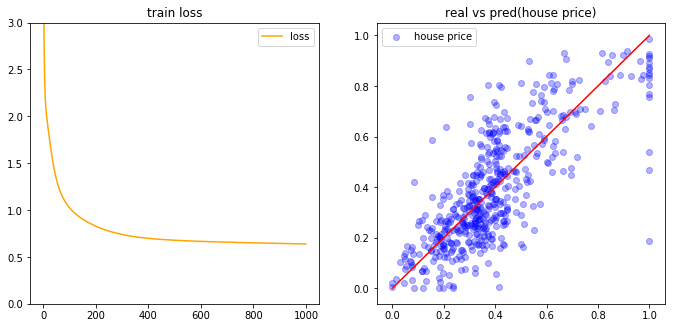

In [8]:
if __name__ == '__main__':
    main()       